In [ ]:
import numpy as np
import nibabel as nib
import os
from scipy import ndimage as ndi

patch_size = (32, 64, 64)
save_root = "patches"
os.makedirs(save_root, exist_ok=True)


import numpy as np
from skimage.measure import label, regionprops

def extract_patch_strict_rprops(mask, image, centroid, patch_size, connectivity=1, margin=0):
    Pz, Py, Px = patch_size
    Z, Y, X = mask.shape
    if Z < Pz or Y < Py or X < Px:
        return None, None

    cz, cy, cx = map(lambda v: int(round(v)), centroid)
    def clamp_start(start, P, L): return max(0, min(start, L - P))
    sz = clamp_start(cz - Pz // 2, Pz, Z); ez = sz + Pz
    sy = clamp_start(cy - Py // 2, Py, Y); ey = sy + Py
    sx = clamp_start(cx - Px // 2, Px, X); ex = sx + Px

    z0, y0, x0 = sz + margin, sy + margin, sx + margin
    z1, y1, x1 = ez - margin, ey - margin, ex - margin
    if z0 >= z1 or y0 >= y1 or x0 >= x1:
        return None, None

    labels = label(mask.astype(bool), connectivity=connectivity)
    keep_mask_full = np.zeros_like(mask, dtype=bool)

    for r in regionprops(labels):
        # Быстрая предварительная проверка bbox:
        bz0, by0, bx0, bz1, by1, bx1 = r.bbox
        if not (bz0 >= z0 and by0 >= y0 and bx0 >= x0 and
                bz1 <= z1 and by1 <= y1 and bx1 <= x1):
            continue  # точно есть воксели за окном → пропускаем

        # Строгая проверка по координатам (на случай "почти касания"):
        czs, cys, cxs = r.coords[:,0], r.coords[:,1], r.coords[:,2]
        outside = (
            (czs < z0) | (czs >= z1) |
            (cys < y0) | (cys >= y1) |
            (cxs < x0) | (cxs >= x1)
        )
        if not np.any(outside):
            keep_mask_full[czs, cys, cxs] = True

    patch_mask = keep_mask_full[sz:ez, sy:ey, sx:ex].astype(np.uint8)
    patch_img  = image[sz:ez, sy:ey, sx:ex]
    return patch_mask, patch_img


# --- Основной цикл ---
for idx, row in df.iterrows():
    radius = float(row["bounding_radius"])
    if radius * 2 > min(patch_size):
        print(f"⚠️  Очаг {row['lesion_id']} ({row['patient']}) слишком большой — пропущен.")
        continue

    mask_path = "MSLesSeg Dataset/all_train/" + row["file"]
    patient = row["patient"]
    centroid = (row["centroid_z"], row["centroid_y"], row["centroid_x"])
    lesion_id = int(row["lesion_id"])

    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(np.uint8)
    affine = mask_img.affine
    img_path = mask_path.replace("_MASK", "_FLAIR")
    img_data = nib.load(img_path).get_fdata()

    patch_mask, patch_img = extract_patch_strict_rprops(mask_data, img_data, centroid, patch_size)
    patch_mask = drop_components_touching_border(patch_mask)

    # Сохраняем
    patient_dir = os.path.join(save_root, patient)
    os.makedirs(patient_dir, exist_ok=True)
    base = os.path.basename(mask_path).replace(".nii.gz", "")
    nib.save(nib.Nifti1Image(patch_mask, affine), os.path.join(patient_dir, f"{base}_lesion{lesion_id}_mask.nii.gz"))
    nib.save(nib.Nifti1Image(patch_img, affine), os.path.join(patient_dir, f"{base}_lesion{lesion_id}_image.nii.gz"))

    print(f"✅ {patient} — сохранён патч {lesion_id} ({np.sum(patch_mask)} вокселей).")


✅ P32 — сохранён патч 1 (94 вокселей).
✅ P32 — сохранён патч 2 (382 вокселей).
✅ P32 — сохранён патч 3 (94 вокселей).
⚠️  Очаг 4 (P32) слишком большой — пропущен.
✅ P32 — сохранён патч 5 (2 вокселей).
✅ P32 — сохранён патч 6 (331 вокселей).
✅ P32 — сохранён патч 7 (462 вокселей).
✅ P32 — сохранён патч 8 (325 вокселей).
✅ P32 — сохранён патч 9 (175 вокселей).
✅ P32 — сохранён патч 10 (140 вокселей).
✅ P32 — сохранён патч 11 (140 вокселей).
✅ P32 — сохранён патч 12 (196 вокселей).
✅ P44 — сохранён патч 1 (208 вокселей).
✅ P44 — сохранён патч 2 (169 вокселей).
✅ P44 — сохранён патч 3 (253 вокселей).
✅ P44 — сохранён патч 4 (1566 вокселей).
✅ P44 — сохранён патч 5 (34 вокселей).
✅ P44 — сохранён патч 6 (52 вокселей).
✅ P44 — сохранён патч 7 (1693 вокселей).
✅ P44 — сохранён патч 8 (1641 вокселей).
✅ P44 — сохранён патч 9 (1641 вокселей).
✅ P44 — сохранён патч 10 (288 вокселей).
✅ P44 — сохранён патч 11 (46 вокселей).
✅ P8 — сохранён патч 1 (445 вокселей).
✅ P8 — сохранён патч 2 (269 воксел

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import nibabel as nib
from skimage.measure import label, regionprops

# === Настройки ===
patch_size = (32, 64, 64)
save_root = "patches"
os.makedirs(save_root, exist_ok=True)

# Папка с 78 здоровыми изображениями
healthy_root = "/content/healthy_mri/healthy_mri_flair"  # <-- поменяй путь на свой
healthy_files = sorted([os.path.join(healthy_root, f) for f in os.listdir(healthy_root) if f.endswith(".nii.gz")])
assert len(healthy_files) >= 1, "Не найдено здоровых изображений!"

# CSV для координат здоровых патчей
healthy_csv_path = os.path.join(save_root, "healthy_patch_centers.csv")
healthy_records = []


def extract_patch_strict_rprops(mask, image, centroid, patch_size, connectivity=1, margin=0):
    Pz, Py, Px = patch_size
    Z, Y, X = mask.shape
    if Z < Pz or Y < Py or X < Px:
        return None, None

    cz, cy, cx = map(lambda v: int(round(v)), centroid)
    def clamp_start(start, P, L): return max(0, min(start, L - P))
    sz = clamp_start(cz - Pz // 2, Pz, Z); ez = sz + Pz
    sy = clamp_start(cy - Py // 2, Py, Y); ey = sy + Py
    sx = clamp_start(cx - Px // 2, Px, X); ex = sx + Px

    z0, y0, x0 = sz + margin, sy + margin, sx + margin
    z1, y1, x1 = ez - margin, ey - margin, ex - margin
    if z0 >= z1 or y0 >= y1 or x0 >= x1:
        return None, None

    labels = label(mask.astype(bool), connectivity=connectivity)
    keep_mask_full = np.zeros_like(mask, dtype=bool)

    for r in regionprops(labels):
        bz0, by0, bx0, bz1, by1, bx1 = r.bbox
        if not (bz0 >= z0 and by0 >= y0 and bx0 >= x0 and
                bz1 <= z1 and by1 <= y1 and bx1 <= x1):
            continue

        czs, cys, cxs = r.coords[:, 0], r.coords[:, 1], r.coords[:, 2]
        outside = ((czs < z0) | (czs >= z1) |
                   (cys < y0) | (cys >= y1) |
                   (cxs < x0) | (cxs >= x1))
        if not np.any(outside):
            keep_mask_full[czs, cys, cxs] = True

    patch_mask = keep_mask_full[sz:ez, sy:ey, sx:ex].astype(np.uint8)
    patch_img  = image[sz:ez, sy:ey, sx:ex]
    return patch_mask, patch_img


def drop_components_touching_border(mask):
    labels = label(mask)
    keep_mask = np.zeros_like(mask, dtype=bool)
    for region in regionprops(labels):
        z0, y0, x0, z1, y1, x1 = region.bbox
        if (z0 == 0 or y0 == 0 or x0 == 0 or
            z1 == mask.shape[0] or y1 == mask.shape[1] or x1 == mask.shape[2]):
            continue
        coords = region.coords
        keep_mask[coords[:, 0], coords[:, 1], coords[:, 2]] = True
    return keep_mask.astype(np.uint8)


# --- Основной цикл ---
for idx, row in tqdm(df.iterrows()):
    radius = float(row["bounding_radius"])
    if radius * 2 > min(patch_size):
        print(f"⚠️  Очаг {row['lesion_id']} ({row['patient']}) слишком большой — пропущен.")
        continue

    mask_path = "MSLesSeg Dataset/all_train/" + row["file"]
    patient = row["patient"]
    centroid = (row["centroid_z"], row["centroid_y"], row["centroid_x"])
    lesion_id = int(row["lesion_id"])

    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(np.uint8)
    affine = mask_img.affine
    img_path = mask_path.replace("_MASK", "_FLAIR")
    img_data = nib.load(img_path).get_fdata()

    # === 1️⃣ Вырезаем больной патч ===
    patch_mask, patch_img = extract_patch_strict_rprops(mask_data, img_data, centroid, patch_size)
    patch_mask = drop_components_touching_border(patch_mask)

    patient_dir = os.path.join(save_root, patient)
    os.makedirs(patient_dir, exist_ok=True)
    base = os.path.basename(mask_path).replace(".nii.gz", "")

    nib.save(nib.Nifti1Image(patch_mask, affine),
             os.path.join(patient_dir, f"{base}_lesion{lesion_id}_mask.nii.gz"))
    nib.save(nib.Nifti1Image(patch_img, affine),
             os.path.join(patient_dir, f"{base}_lesion{lesion_id}_image.nii.gz"))

    print(f"✅ {patient} — сохранён патч {lesion_id} ({np.sum(patch_mask)} вокселей).")

    # === 2️⃣ Вырезаем здоровый патч ===
    max_tries = 10
    for attempt in range(max_tries):
        healthy_file = random.choice(healthy_files)
        healthy_img = nib.load(healthy_file)
        healthy_data = healthy_img.get_fdata()

        Pz, Py, Px = patch_size
        cz, cy, cx = map(int, centroid)
        Z, Y, X = healthy_data.shape

        # Корректируем координаты, чтобы не выйти за границы
        sz = max(0, min(cz - Pz // 2, Z - Pz))
        sy = max(0, min(cy - Py // 2, Y - Py))
        sx = max(0, min(cx - Px // 2, X - Px))
        ez, ey, ex = sz + Pz, sy + Py, sx + Px

        healthy_patch = healthy_data[sz:ez, sy:ey, sx:ex]

        # --- Проверка: доля фона ---
        black_ratio = np.mean(healthy_patch == 0)
        if black_ratio > 0.6:
            print(f"⚠️  Патч из {os.path.basename(healthy_file)} содержит {black_ratio:.1%} фона — пропускаем.")
            continue  # попробуем другой файл
        else:
            # нормальный патч найден
            break
    else:
        print(f"❌ Не удалось найти подходящий здоровый патч для {patient} lesion {lesion_id}")
        continue  # если 10 попыток неудачны — пропускаем

    # Сохраняем нормальный патч
    healthy_patient_dir = os.path.join(save_root, "healthy")
    os.makedirs(healthy_patient_dir, exist_ok=True)

    healthy_name = os.path.basename(healthy_file).replace(".nii.gz", "")
    healthy_patch_name = f"{healthy_name}_ctrl_for_{patient}_lesion{lesion_id}.nii.gz"
    nib.save(nib.Nifti1Image(healthy_patch, healthy_img.affine),
             os.path.join(healthy_patient_dir, healthy_patch_name))

    # === 3️⃣ Сохраняем координаты центра ===
    healthy_records.append({
        "healthy_file": healthy_file,
        "output_patch": healthy_patch_name,
        "patient": patient,
        "lesion_id": lesion_id,
        "centroid_z": cz,
        "centroid_y": cy,
        "centroid_x": cx,
        "black_ratio": black_ratio
    })


# === 4️⃣ Сохраняем CSV со здоровыми патчами ===
pd.DataFrame(healthy_records).to_csv(healthy_csv_path, index=False)
print(f"✅ Сохранено {len(healthy_records)} здоровых патчей → {healthy_csv_path}")


0it [00:00, ?it/s]

✅ P42 — сохранён патч 1 (85 вокселей).
✅ P42 — сохранён патч 2 (85 вокселей).
⚠️  Очаг 3 (P42) слишком большой — пропущен.
✅ P42 — сохранён патч 4 (85 вокселей).
✅ P42 — сохранён патч 5 (99 вокселей).
✅ P42 — сохранён патч 6 (35 вокселей).
✅ P42 — сохранён патч 7 (137 вокселей).
✅ P42 — сохранён патч 8 (252 вокселей).
✅ P42 — сохранён патч 9 (252 вокселей).
✅ P42 — сохранён патч 10 (85 вокселей).
✅ P42 — сохранён патч 11 (237 вокселей).
✅ P42 — сохранён патч 12 (267 вокселей).
✅ P42 — сохранён патч 13 (252 вокселей).
✅ P42 — сохранён патч 14 (252 вокселей).
✅ P42 — сохранён патч 15 (499 вокселей).
✅ P42 — сохранён патч 16 (36 вокселей).
✅ P42 — сохранён патч 17 (36 вокселей).
✅ P42 — сохранён патч 18 (36 вокселей).
✅ P42 — сохранён патч 19 (375 вокселей).
✅ P42 — сохранён патч 20 (733 вокселей).
✅ P42 — сохранён патч 21 (15 вокселей).
✅ P42 — сохранён патч 22 (15 вокселей).
✅ P42 — сохранён патч 23 (37 вокселей).
✅ P42 — сохранён патч 24 (62 вокселей).
✅ P42 — сохранён патч 25 (363 вок

In [ ]:
!zip -r "healthy.zip" patches/healthy

  adding: patches/healthy/ (stored 0%)
  adding: patches/healthy/sub-00054_fl_brain-final_ctrl_for_P29_lesion9.nii.gz (deflated 0%)
  adding: patches/healthy/sub-00147_fl_brain-final_ctrl_for_P19_lesion5.nii.gz (deflated 0%)
  adding: patches/healthy/sub-00170_fl_brain-final_ctrl_for_P53_lesion2.nii.gz (deflated 0%)
  adding: patches/healthy/sub-00088_fl_brain-final_ctrl_for_P39_lesion16.nii.gz (deflated 0%)
  adding: patches/healthy/sub-00084_fl_brain-final_ctrl_for_P6_lesion13.nii.gz (deflated 0%)
  adding: patches/healthy/sub-00007_fl_brain-final_ctrl_for_P12_lesion33.nii.gz (deflated 0%)
  adding: patches/healthy/sub-00057_fl_brain-final_ctrl_for_P49_lesion16.nii.gz (deflated 0%)
  adding: patches/healthy/sub-00150_fl_brain-final_ctrl_for_P14_lesion27.nii.gz (deflated 0%)
  adding: patches/healthy/sub-00096_fl_brain-final_ctrl_for_P4_lesion21.nii.gz (deflated 0%)
  adding: patches/healthy/sub-C2_fl_brain-final_ctrl_for_P2_lesion3.nii.gz (deflated 0%)
  adding: patches/healthy/sub-0

In [ ]:
 !rm -r patches

In [ ]:
!zip -r "masks.zip" patches

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: patches/P8/P8_T2_MASK_lesion20_mask.nii.gz (deflated 27%)
  adding: patches/P8/P8_T1_MASK_lesion5_image.nii.gz (deflated 3%)
  adding: patches/P8/P8_T2_MASK_lesion3_mask.nii.gz (deflated 64%)
  adding: patches/P8/P8_T1_MASK_lesion15_mask.nii.gz (deflated 16%)
  adding: patches/P8/P8_T2_MASK_lesion8_mask.nii.gz (deflated 39%)
  adding: patches/P8/P8_T1_MASK_lesion2_image.nii.gz (deflated 3%)
  adding: patches/P34/ (stored 0%)
  adding: patches/P34/P34_T1_MASK_lesion27_mask.nii.gz (deflated 27%)
  adding: patches/P34/P34_T1_MASK_lesion13_mask.nii.gz (deflated 17%)
  adding: patches/P34/P34_T1_MASK_lesion7_image.nii.gz (deflated 0%)
  adding: patches/P34/P34_T1_MASK_lesion5_image.nii.gz (deflated 0%)
  adding: patches/P34/P34_T1_MASK_lesion29_mask.nii.gz (deflated 16%)
  adding: patches/P34/P34_T1_MASK_lesion21_mask.nii.gz (deflated 14%)
  adding: patches/P34/P34_T1_MASK_lesion9_mask.nii.gz (deflated 15%)
  addi

In [ ]:
import os
import shutil

source_root = "MSLesSeg Dataset/train"
target_root = "MSLesSeg Dataset/all_train"
os.makedirs(target_root, exist_ok=True)

count = 0
for root, dirs, files in os.walk(source_root):
    for f in files:
        if f.endswith(".nii.gz"):
            src = os.path.join(root, f)
            dst = os.path.join(target_root, f)
            shutil.copy2(src, dst)
            count += 1
            print(f"📦 {f} → {target_root}/")

print(f"\n✅ Скопировано {count} файлов в папку '{target_root}'")


📦 P42_T1_T1.nii.gz → MSLesSeg Dataset/all_train/
📦 P42_T1_FLAIR.nii.gz → MSLesSeg Dataset/all_train/
📦 P42_T1_MASK.nii.gz → MSLesSeg Dataset/all_train/
📦 P42_T1_T2.nii.gz → MSLesSeg Dataset/all_train/
📦 P48_T1_T2.nii.gz → MSLesSeg Dataset/all_train/
📦 P48_T1_T1.nii.gz → MSLesSeg Dataset/all_train/
📦 P48_T1_MASK.nii.gz → MSLesSeg Dataset/all_train/
📦 P48_T1_FLAIR.nii.gz → MSLesSeg Dataset/all_train/
📦 P49_T1_T1.nii.gz → MSLesSeg Dataset/all_train/
📦 P49_T1_T2.nii.gz → MSLesSeg Dataset/all_train/
📦 P49_T1_MASK.nii.gz → MSLesSeg Dataset/all_train/
📦 P49_T1_FLAIR.nii.gz → MSLesSeg Dataset/all_train/
📦 P49_T2_T1.nii.gz → MSLesSeg Dataset/all_train/
📦 P49_T2_FLAIR.nii.gz → MSLesSeg Dataset/all_train/
📦 P49_T2_T2.nii.gz → MSLesSeg Dataset/all_train/
📦 P49_T2_MASK.nii.gz → MSLesSeg Dataset/all_train/
📦 P2_T1_T2.nii.gz → MSLesSeg Dataset/all_train/
📦 P2_T1_FLAIR.nii.gz → MSLesSeg Dataset/all_train/
📦 P2_T1_MASK.nii.gz → MSLesSeg Dataset/all_train/
📦 P2_T1_T1.nii.gz → MSLesSeg Dataset/all_train/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/MSLesSeg Dataset.zip"
# !unzip "/content/drive/My Drive/healthy_mri.zip"


   creating: MSLesSeg Dataset/test/P58/
  inflating: MSLesSeg Dataset/test/P58/P58_FLAIR.nii.gz  
  inflating: MSLesSeg Dataset/test/P58/P58_MASK.nii.gz  
  inflating: MSLesSeg Dataset/test/P58/P58_T1.nii.gz  
  inflating: MSLesSeg Dataset/test/P58/P58_T2.nii.gz  
   creating: MSLesSeg Dataset/test/P59/
  inflating: MSLesSeg Dataset/test/P59/P59_FLAIR.nii.gz  
  inflating: MSLesSeg Dataset/test/P59/P59_MASK.nii.gz  
  inflating: MSLesSeg Dataset/test/P59/P59_T1.nii.gz  
  inflating: MSLesSeg Dataset/test/P59/P59_T2.nii.gz  
   creating: MSLesSeg Dataset/test/P60/
  inflating: MSLesSeg Dataset/test/P60/P60_FLAIR.nii.gz  
  inflating: MSLesSeg Dataset/test/P60/P60_MASK.nii.gz  
  inflating: MSLesSeg Dataset/test/P60/P60_T1.nii.gz  
  inflating: MSLesSeg Dataset/test/P60/P60_T2.nii.gz  
   creating: MSLesSeg Dataset/test/P61/
  inflating: MSLesSeg Dataset/test/P61/P61_FLAIR.nii.gz  
  inflating: MSLesSeg Dataset/test/P61/P61_MASK.nii.gz  
  inflating: MSLesSeg Dataset/test/P61/P61_T1.nii

In [ ]:
!pip install nibabel matplotlib

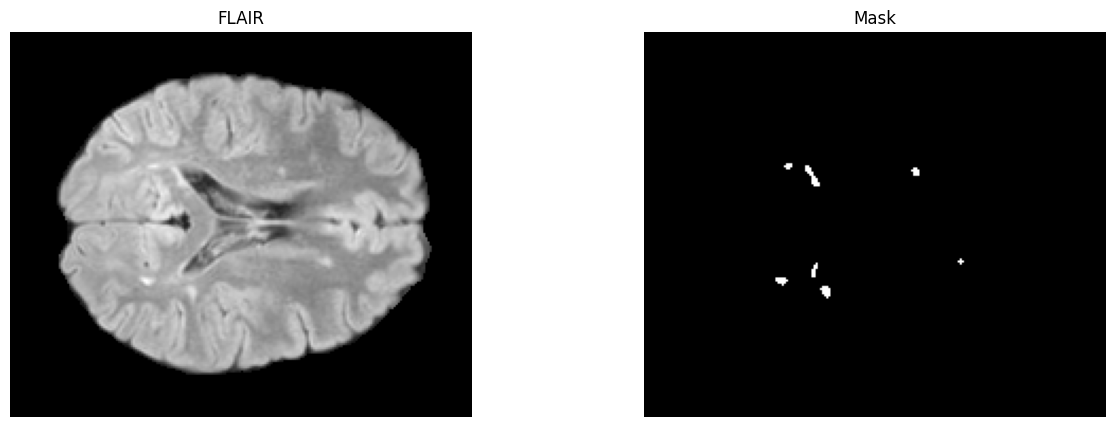

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Path to a few sample files
mask_path = "/content/MSLesSeg Dataset/train/P10/T1/P10_T1_MASK.nii.gz"
t1_path   = "/content/MSLesSeg Dataset/train/P10/T1/P10_T1_FLAIR.nii.gz"

# Load NIfTI images
mask_img = nib.load(mask_path)
t1_img   = nib.load(t1_path)
# Convert to numpy arrays
mask_data = mask_img.get_fdata()
t1_data   = t1_img.get_fdata()

# Choose a middle slice (for example, axial)
slice_idx = mask_data.shape[2] // 2

# Plot the slices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(t1_data[:, :, slice_idx], cmap='gray')
axes[0].set_title('FLAIR')
axes[1].imshow(mask_data[:, :, slice_idx], cmap='gray')
axes[1].set_title('Mask')
for ax in axes:
    ax.axis('off')

plt.savefig("initial_data.png", format='png', dpi=300)
plt.show()

voxel sizes: [1. 1. 1.]


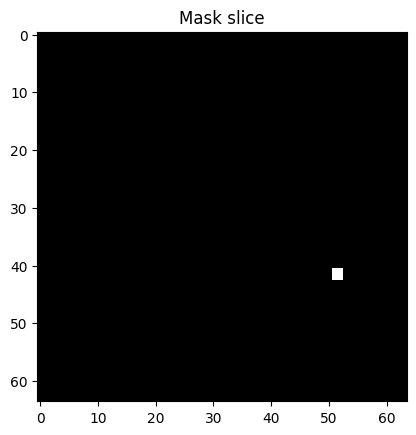

In [28]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Path to a few sample files
mask_path = "/content/46_GenMask.nii.gz"
# t1_path   = "/content/MSLesSeg Dataset/all_train/P32_T1_FLAIR.nii.gz"
# t2_path   = "/content/MSLesSeg Dataset/all_train/P32_T1_T2.nii.gz"

# Load NIfTI images
img = nib.load(mask_path)
data = img.get_fdata()
voxel_sizes = np.sqrt((img.affine[:3, :3] ** 2).sum(0))
print("voxel sizes:", voxel_sizes)

slice_idx = 22


plt.imshow(data[slice_idx, :, :], cmap='gray',
           aspect=voxel_sizes[1]/voxel_sizes[2])
plt.title("Mask slice")
plt.show()

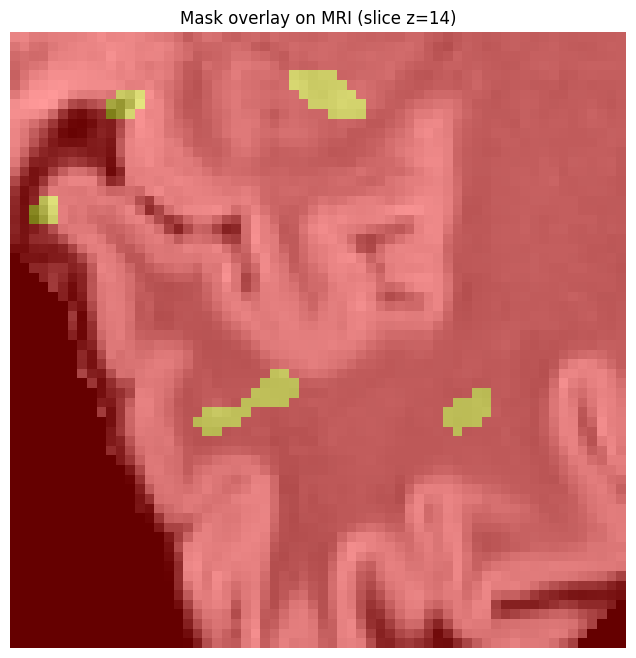

Saved overlay image at: /content/mask_overlay_mri.png


In [ ]:
9import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# === file paths ===
mask_path = "/content/mask_thr_0.80_vox1078.nii.gz"
image_path = "sub-00127_fl_brain-final_ctrl_for_P42_lesion13.nii.gz"

# === load data ===
mask = nib.load(mask_path).get_fdata()
img = nib.load(image_path).get_fdata()

# --- select slice (manually or based on the center of the mask) ---
# Find the slice where the mask is most prominent:
z_index = np.argmax(np.sum(mask, axis=(1, 2)))

# --- normalize the image for better contrast ---
norm_img = (img - np.min(img)) / (np.ptp(img) + 1e-8)

# --- create overlay ---
plt.figure(figsize=(8, 8))
plt.imshow(norm_img[z_index, :, :], cmap="gray")
plt.imshow(mask[z_index, :, :], cmap="autumn", alpha=0.4)  # red translucent mask
plt.title(f"Mask overlay on MRI (slice z={z_index})")
plt.axis("off")

# Save the plot to a PNG file
png_path = "/content/mask_overlay_mri.png"
plt.savefig(png_path, format='png', dpi=300)

plt.show()

# Print saved file path
print(f"Saved overlay image at: {png_path}")



In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from scipy.spatial import ConvexHull
from tqdm.auto import tqdm

In [ ]:
def analyze_mask(mask_path):
    """
    Analyze one NIfTI mask file:
    - Count lesions
    - Get bounding circle (center, radius)
    - Compute area/volume stats
    """
    img = nib.load(mask_path)
    data = img.get_fdata()

    # Binary mask (assuming lesions > 0)
    mask = (data > 0).astype(np.uint8)

    # Connected components
    labeled = label(mask, connectivity=1)
    regions = regionprops(labeled)

    lesion_stats = []

    for region in regions:
        coords = region.coords
        z, y, x = coords[:,0], coords[:,1], coords[:,2]

        # Compute 3D centroid
        centroid = np.mean(coords, axis=0)

        # 3D bounding circle radius (use max distance from centroid)
        distances = np.linalg.norm(coords - centroid, axis=1)
        radius = np.max(distances)

        lesion_stats.append({
            "lesion_id": region.label,
            "volume_voxels": len(coords),
            "centroid_z": centroid[0],
            "centroid_y": centroid[1],
            "centroid_x": centroid[2],
            "bounding_radius": radius
        })

    return lesion_stats


In [ ]:
def count_files_recursive(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

In [ ]:
# count_files_recursive(mask_dir) / 4

In [ ]:
mask_dir = "/content/MSLesSeg Dataset/train"
all_stats = []

for root, dirs, files in tqdm(os.walk(mask_dir), total=93):
    for file in files:
        if file.endswith("_MASK.nii.gz"):
            mask_path = os.path.join(root, file)
            patient_id = root.split("/")[-2]  # e.g. P8
            seq = root.split("/")[-1]         # e.g. T2

            lesion_data = analyze_mask(mask_path)
            for lesion in lesion_data:
                lesion["patient"] = patient_id
                lesion["sequence"] = seq
                lesion["file"] = file
                all_stats.append(lesion)

df = pd.DataFrame(all_stats)
df.head()


  0%|          | 0/93 [00:00<?, ?it/s]

,lesion_id,volume_voxels,centroid_z,centroid_y,centroid_x,bounding_radius,patient,sequence,file
0,1,30,37.900000,122.666667,89.666667,2.994254,P42,T1,P42_T1_MASK.nii.gz
1,2,43,38.860465,100.069767,90.558140,2.742609,P42,T1,P42_T1_MASK.nii.gz
2,3,39307,88.018495,96.640064,92.177526,68.543887,P42,T1,P42_T1_MASK.nii.gz
3,4,12,49.500000,118.500000,94.000000,1.581139,P42,T1,P42_T1_MASK.nii.gz
4,5,52,49.807692,133.423077,40.519231,3.734584,P42,T1,P42_T1_MASK.nii.gz


In [ ]:
!unzip patches_refined.zip

In [ ]:
df[df['patient']=='P39']

,lesion_id,volume_voxels,centroid_z,centroid_y,centroid_x,bounding_radius,patient,sequence,file
393,1,41,31.487805,127.536585,91.756098,2.383889,P39,T1,P39_T1_MASK.nii.gz
394,2,431,42.631090,127.709977,84.067285,7.821065,P39,T1,P39_T1_MASK.nii.gz
395,3,312,42.602564,124.676282,113.365385,7.420439,P39,T1,P39_T1_MASK.nii.gz
396,4,67904,94.441299,106.275271,90.267584,68.328623,P39,T1,P39_T1_MASK.nii.gz
397,5,88,48.215909,69.238636,111.181818,4.008546,P39,T1,P39_T1_MASK.nii.gz
398,6,276,52.692029,100.532609,107.163043,5.911119,P39,T1,P39_T1_MASK.nii.gz
399,7,142,52.478873,168.845070,91.957746,4.202804,P39,T1,P39_T1_MASK.nii.gz
400,8,1,52.000000,95.000000,69.000000,0.000000,P39,T1,P39_T1_MASK.nii.gz
401,9,2,56.500000,101.000000,112.000000,0.500000,P39,T1,P39_T1_MASK.nii.gz
402,10,25,59.640000,117.920000,98.520000,2.174029,P39,T1,P39_T1_MASK.nii.gz


In [ ]:
df_filtered = df[df['volume_voxels'] <= 1000]

Total lesions detected: 2688
Patients analyzed: 53

Lesion volume (voxels):
count     2688.000000
mean       420.965774
std       2323.723805
min          1.000000
25%         30.000000
50%         64.000000
75%        147.000000
max      67904.000000
Name: volume_voxels, dtype: float64


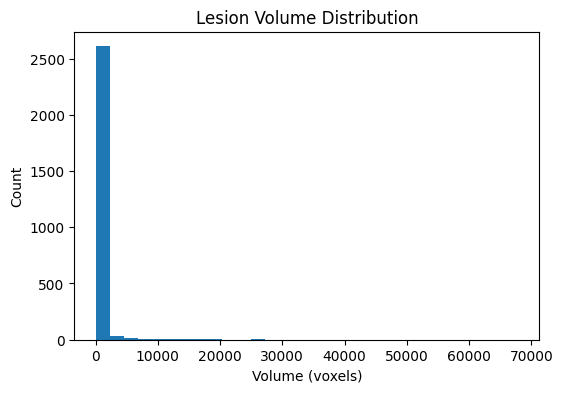

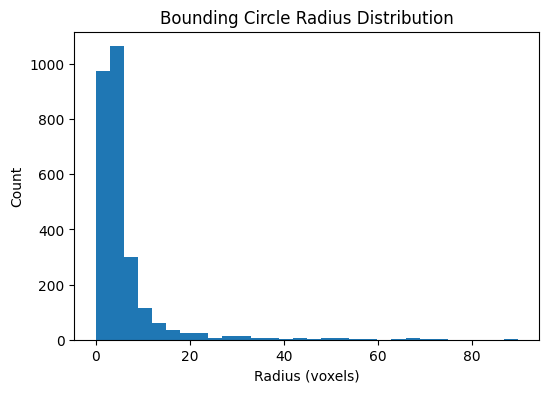

In [ ]:
print(f"Total lesions detected: {len(df)}")
print(f"Patients analyzed: {df['patient'].nunique()}")

print("\nLesion volume (voxels):")
print(df['volume_voxels'].describe())

plt.figure(figsize=(6,4))
plt.hist(df['volume_voxels'], bins=30)
plt.title('Lesion Volume Distribution')
plt.xlabel('Volume (voxels)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['bounding_radius'], bins=30)
plt.title('Bounding Circle Radius Distribution')
plt.xlabel('Radius (voxels)')
plt.ylabel('Count')
plt.show()

Total lesions detected: 2550
Patients analyzed: 53

Lesion volume (voxels):
count    2550.000000
mean      111.738039
std       153.770849
min         1.000000
25%        28.000000
50%        59.000000
75%       123.000000
max       999.000000
Name: volume_voxels, dtype: float64


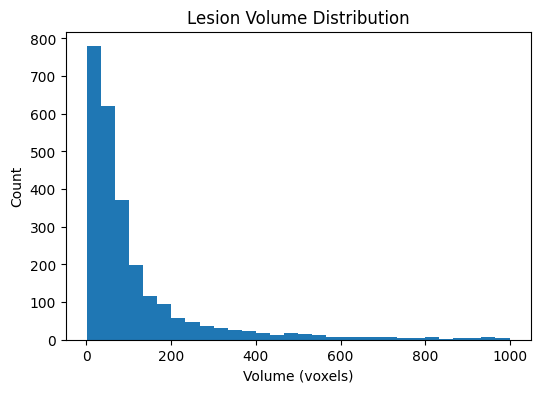

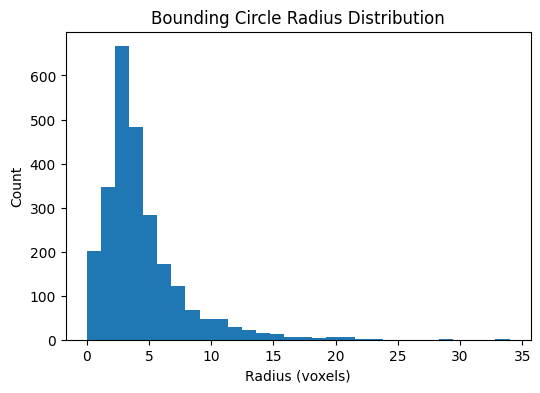

In [ ]:
print(f"Total lesions detected: {len(df_filtered)}")
print(f"Patients analyzed: {df_filtered['patient'].nunique()}")

print("\nLesion volume (voxels):")
print(df_filtered['volume_voxels'].describe())

plt.figure(figsize=(6,4))
plt.hist(df_filtered['volume_voxels'], bins=30)
plt.title('Lesion Volume Distribution')
plt.xlabel('Volume (voxels)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_filtered['bounding_radius'], bins=30)
plt.title('Bounding Circle Radius Distribution')
plt.xlabel('Radius (voxels)')
plt.ylabel('Count')
plt.show()

In [ ]:
cnt_per_pat = df.groupby('patient').count()['lesion_id']

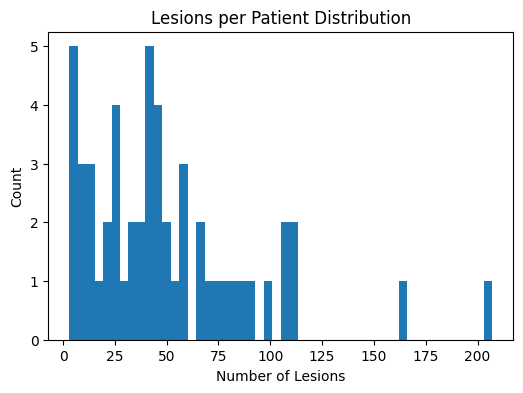

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(cnt_per_pat, bins=50)
plt.title('Lesions per Patient Distribution')
plt.xlabel('Number of Lesions')
plt.ylabel('Count')
plt.show()

In [ ]:
df['volume_voxels'].quantile(0.95)

np.float64(1035.7500000000014)

In [ ]:
largest_lesion = df.loc[df['volume_voxels'].idxmax()]
largest_lesion

,2535
lesion_id,4
volume_voxels,67904
centroid_z,94.441299
centroid_y,106.275271
centroid_x,90.267584
bounding_radius,68.328623
patient,P39
sequence,T1
file,P39_T1_MASK.nii.gz


In [ ]:
mask_path = os.path.join(mask_dir, largest_lesion["patient"], largest_lesion["sequence"], largest_lesion["file"])
print("Mask file:", mask_path)
print("Lesion volume (voxels):", largest_lesion["volume_voxels"])

Mask file: /content/MSLesSeg Dataset/train/P39/T1/P39_T1_MASK.nii.gz
Lesion volume (voxels): 67904


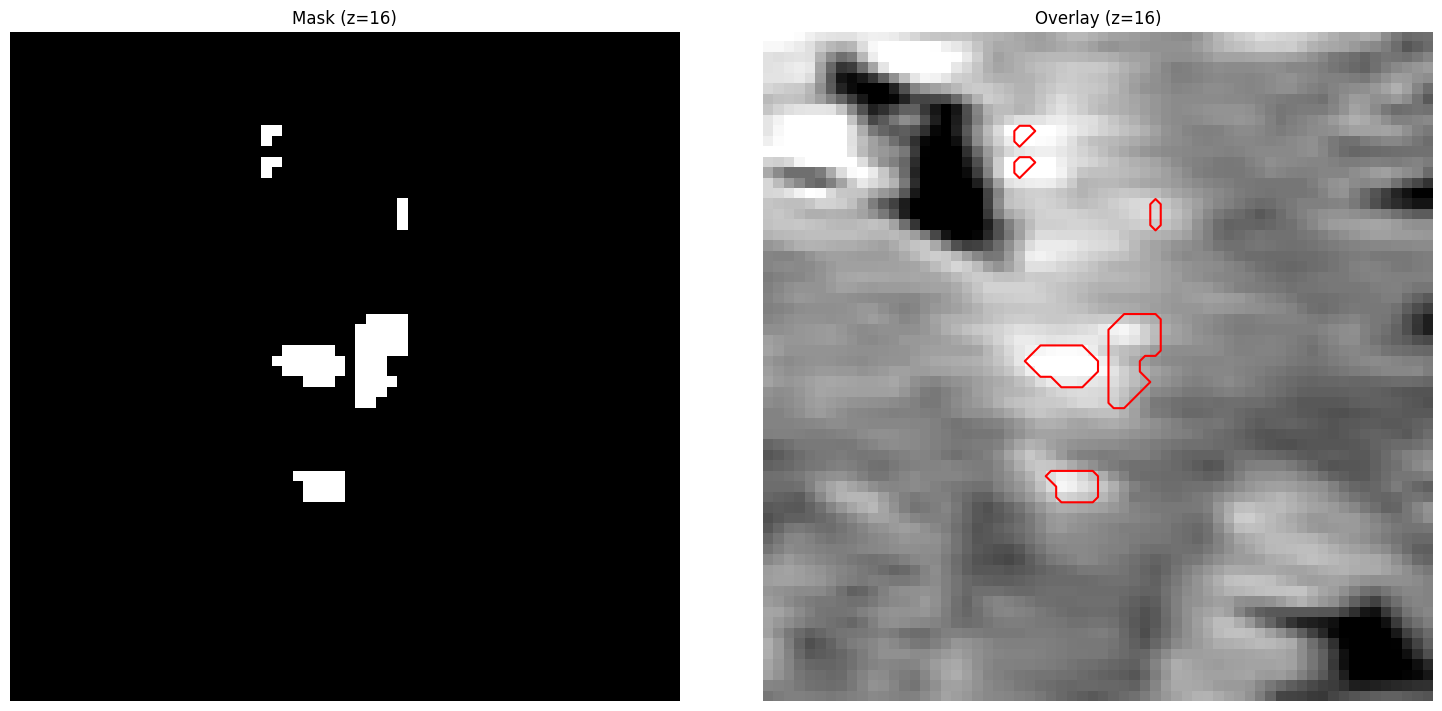

Saved PNG with both mask and overlay at: /content/overlay_and_mask.png


In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# --- маска ---
mask_path = "/content/patches/P10/P10_T1_MASK_lesion10_mask.nii.gz"
mask_img  = nib.load(mask_path)
mask_data = mask_img.get_fdata()

# --- сопоставимое изображение (тот же патч) ---
img_path = mask_path.replace("_mask.nii.gz", "_image.nii.gz")
img_data = nib.load(img_path).get_fdata()

# находим самый большой очаг и его центральный срез (как у тебя)
labeled  = label(mask_data > 0)
regions  = regionprops(labeled)
largest  = max(regions, key=lambda r: len(r.coords))
coords   = largest.coords
centroid = np.mean(coords, axis=0)

z_slice = int(round(centroid[0]))

# вытаскиваем 2D-срезы
slice_mask = mask_data[z_slice, :, :]
slice_img  = img_data[z_slice, :, :]

# аккуратный контраст для изображения
finite = np.isfinite(slice_img)
p2, p98 = np.percentile(slice_img[finite], [2, 98])
vmin, vmax = float(p2), float(p98)

# РИСУЕМ ДВА ГРАФИКА: один с маской, другой с наложением
fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)

# 1. Маска
axes[0].imshow(slice_mask, cmap="gray")
axes[0].set_title(f"Mask (z={z_slice})")
axes[0].axis("off")

# 2. Наложение изображения и маски
axes[1].imshow(slice_img, cmap="gray", vmin=vmin, vmax=vmax)
axes[1].contour(slice_mask > 0.5, levels=[0.5], linewidths=1.5, colors='r')  # контур маски
axes[1].set_title(f"Overlay (z={z_slice})")
axes[1].axis("off")

# Сохраняем в PNG
png_path = "/content/overlay_and_mask.png"
plt.savefig(png_path, format='png', dpi=300)

plt.show()

# Выведем путь сохранения
print(f"Saved PNG with both mask and overlay at: {png_path}")


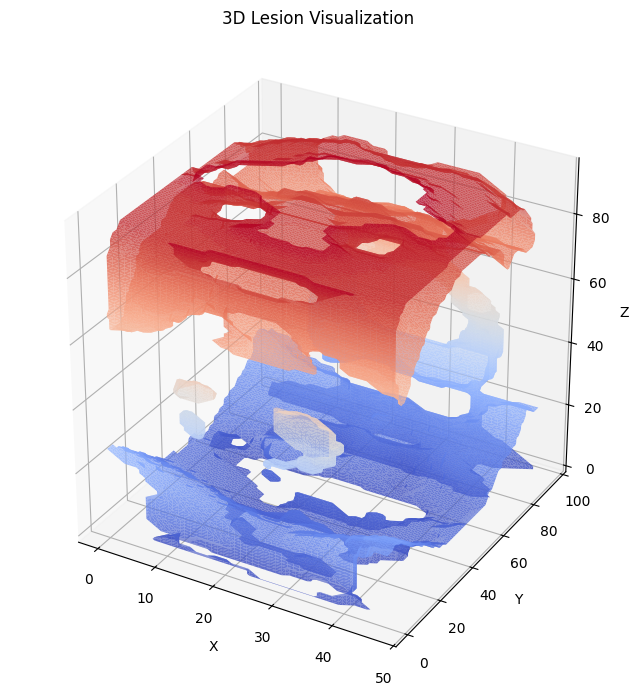

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, marching_cubes

# Load mask file
mask_img = nib.load("/content/P23_T1_MASK_lesion3_GenMask.nii.gz")
mask_data = mask_img.get_fdata()

# Label connected components
labeled = label(mask_data > 0)
regions = regionprops(labeled)

# Get the largest lesion region
largest_region = max(regions, key=lambda r: len(r.coords))
coords = largest_region.coords

# Create a binary mask only for that lesion
lesion_mask = np.zeros_like(mask_data)
lesion_mask[tuple(coords.T)] = 1

# Use marching cubes to generate surface mesh
verts, faces, normals, values = marching_cubes(lesion_mask, level=0.5)

# Plot the 3D mesh
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(
    verts[:, 0], verts[:, 1], faces, verts[:, 2],
    cmap='coolwarm', lw=0.3, alpha=0.8
)

ax.set_title(f"3D Lesion Visualization\n")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Set equal aspect ratio for better view
ax.set_box_aspect([1, 1, 1])

plt.show()


Shape (z, y, x): (32, 64, 64)
Voxel size (mm): [1. 1. 1.]
Data range: (np.float64(9.0), np.float64(364.0))


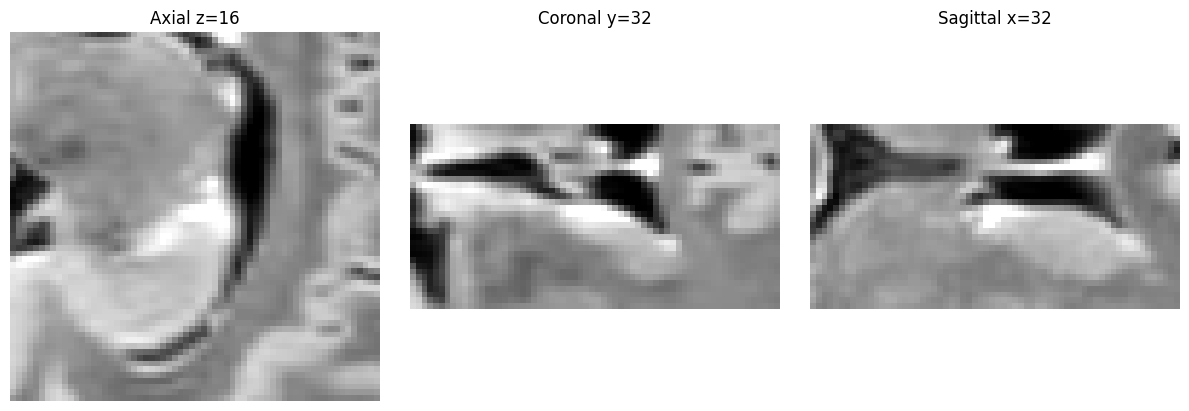

In [ ]:
# pip install nibabel matplotlib numpy ipywidgets
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nibabel.affines import voxel_sizes

# ===== укажите путь к вашему файлу =====
nii_path = "/content/0_GenMask.nii.gz"

# Загрузка
img = nib.load(nii_path)
data = img.get_fdata()         # float64 массив (Z,Y,X) в voxel space
affine = img.affine

print("Shape (z, y, x):", data.shape)
print("Voxel size (mm):", np.round(np.sqrt((affine[:3,:3]**2).sum(axis=0)), 3))
print("Data range:", (np.nanmin(data), np.nanmax(data)))

# Размеры по вокселям
nz, ny, nx = data.shape
# Размеры в мм (x, y, z)
vx, vy, vz = voxel_sizes(affine)
Lx, Ly, Lz = nx * vx, ny * vy, nz * vz

# Контраст (общий для всех срезов)
finite = np.isfinite(data)
p1, p99 = np.percentile(data[finite], [1, 99])
vmin, vmax = p1, p99

# Индексы центральных срезов
iz, iy, ix = nz // 2, ny // 2, nx // 2

# Подготовим сами срезы (без rot90, чтобы проще задать extent)
axial   = np.flipud(data[iz, :, :])   # (Y, X)
coronal = np.flipud(data[:, iy, :])   # (Z, X)
sagitt  = np.flipud(data[:, :, ix])   # (Z, Y)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Очень важно: делаем все панели квадратными и одинаковыми
for ax in axes:
    ax.set_box_aspect(1)        # 1:1 — квадрат
    ax.axis("off")

# Показываем в физических координатах (мм) через extent
# Axial (X по горизонтали, Y по вертикали):
axes[0].imshow(axial, cmap="gray", vmin=vmin, vmax=vmax,
               extent=[0, Lx, 0, Ly], origin="lower")
axes[0].set_title(f"Axial z={iz}")

# Coronal (X по горизонтали, Z по вертикали):
axes[1].imshow(coronal, cmap="gray", vmin=vmin, vmax=vmax,
               extent=[0, Lx, 0, Lz], origin="lower")
axes[1].set_title(f"Coronal y={iy}")

# Sagittal (Y по горизонтали, Z по вертикали):
axes[2].imshow(sagitt, cmap="gray", vmin=vmin, vmax=vmax,
               extent=[0, Ly, 0, Lz], origin="lower")
axes[2].set_title(f"Sagittal x={ix}")

plt.show()

In [ ]:
!pip install -U kaleido


In [35]:
# pip install nibabel numpy scikit-image plotly
import nibabel as nib
import numpy as np
from skimage.measure import marching_cubes
import plotly.graph_objects as go
from nibabel.affines import voxel_sizes
import plotly.io as pio

nii_path = "/content/P1_T1_MASK_lesion4.nii.gz"
img = nib.load(nii_path)
data = img.get_fdata()
aff = img.affine
vx, vy, vz = voxel_sizes(aff)

# Выберем уровень изоповерхности по перцентилю (подстроите под ваши данные)
thr = np.percentile(data[np.isfinite(data)], 70)

# marching_cubes ожидает (z, y, x)
verts, faces, normals, values = marching_cubes(data, level=thr, spacing=(vz, vy, vx))
# spacing=(vz, vy, vx) даёт вершины сразу в миллиметрах!

mesh = go.Mesh3d(
    x=verts[:, 2], y=verts[:, 1], z=verts[:, 0],  # (x, y, z) из (z, y, x)
    i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
    opacity=0.6, flatshading=True
)

fig = go.Figure(mesh)
fig.update_layout(
    width=900, height=700,
    scene=dict(
        xaxis_title="X (mm)", yaxis_title="Y (mm)", zaxis_title="Z (mm)",
        aspectmode="data"
    ),
    title=f"Isosurface at {thr:.2f}"
)

# Save the figure as an HTML file
html_path = "/content/isosurface_initial1.html"
fig.write_html(html_path)

# Save the figure as a PNG file with high resolution using Kaleido
# png_path = "/content/isosurface_genMask2.png"
# pio.write_image(fig, png_path, scale=10)  # scale=10 increases the resolution

# # Optionally, you can print paths for easy access
print(f"HTML saved at: {html_path}")
# print(f"PNG saved at: {png_path}")

fig.show()




HTML saved at: /content/isosurface_initial1.html


In [ ]:
import kaleido
print(kaleido)

<module 'kaleido' from '/usr/local/lib/python3.12/dist-packages/kaleido/__init__.py'>


In [ ]:
!zip -r "patches_refined.zip" patches

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: patches/P8/P8_T2_MASK_lesion20_mask.nii.gz (deflated 35%)
  adding: patches/P8/P8_T1_MASK_lesion5_image.nii.gz (deflated 3%)
  adding: patches/P8/P8_T2_MASK_lesion3_mask.nii.gz (deflated 64%)
  adding: patches/P8/P8_T1_MASK_lesion15_mask.nii.gz (deflated 24%)
  adding: patches/P8/P8_T2_MASK_lesion8_mask.nii.gz (deflated 62%)
  adding: patches/P8/P8_T1_MASK_lesion2_image.nii.gz (deflated 3%)
  adding: patches/P34/ (stored 0%)
  adding: patches/P34/P34_T1_MASK_lesion27_mask.nii.gz (deflated 47%)
  adding: patches/P34/P34_T1_MASK_lesion13_mask.nii.gz (deflated 27%)
  adding: patches/P34/P34_T1_MASK_lesion7_image.nii.gz (deflated 0%)
  adding: patches/P34/P34_T1_MASK_lesion5_image.nii.gz (deflated 0%)
  adding: patches/P34/P34_T1_MASK_lesion29_mask.nii.gz (deflated 47%)
  adding: patches/P34/P34_T1_MASK_lesion21_mask.nii.gz (deflated 22%)
  adding: patches/P34/P34_T1_MASK_lesion9_mask.nii.gz (deflated 44%)
  addi

In [ ]:
img.shape

(32, 64, 64)

In [ ]:
import numpy as np
from skimage.measure import label

def drop_components_touching_border(patch_mask, connectivity=1, margin=0):
    """
    Удаляет из 3D-бинарной маски все компоненты, которые соприкасаются с краем объёма.
    patch_mask: ndarray (Z, Y, X), bool/0-1
    connectivity: 1 -> 6-связность, 2 -> 18/26 (см. skimage)
    margin: сколько слоёв от края считать границей (0 = только внешний слой)
    """
    m = (patch_mask > 0)
    if not np.any(m):
        return patch_mask.astype(np.uint8)

    labels = label(m, connectivity=connectivity)
    nlab = labels.max()
    if nlab == 0:
        return np.zeros_like(patch_mask, dtype=np.uint8)

    Z, Y, X = m.shape
    margin = int(max(0, margin))
    # маска границы (включая margin слоёв)
    B = np.zeros_like(m, dtype=bool)
    z0 = slice(0, min(Z, margin+1))
    z1 = slice(max(0, Z-margin-1), Z)
    y0 = slice(0, min(Y, margin+1))
    y1 = slice(max(0, Y-margin-1), Y)
    x0 = slice(0, min(X, margin+1))
    x1 = slice(max(0, X-margin-1), X)
    B[z0, :, :] = True; B[z1, :, :] = True
    B[:, y0, :] = True; B[:, y1, :] = True
    B[:, :, x0] = True; B[:, :, x1] = True

    # какие метки присутствуют на границе
    border_labels = np.unique(labels[B])
    border_labels = border_labels[border_labels != 0]  # убрать фон

    # оставить всё, что НЕ на границе
    cleaned = (labels > 0) & ~np.isin(labels, border_labels)
    return cleaned.astype(np.uint8)

    import nibabel as nib
import os

mask_path = "/content/patches/P32/P32_T1_MASK_lesion2_mask.nii.gz"
img = nib.load(mask_path)
patch_mask = img.get_fdata()

clean_mask = drop_components_touching_border(patch_mask, connectivity=1, margin=0)

nib.save(nib.Nifti1Image(clean_mask, img.affine, img.header),
         mask_path.replace("_mask.nii.gz", "_mask_clean.nii.gz"))
print("Оставлено вокселей:", int(clean_mask.sum()))


Оставлено вокселей: 382


In [ ]:
import nibabel as nib
import numpy as np
from skimage.measure import label, regionprops

# Load mask
mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

# Find largest lesion
labeled = label(mask_data > 0)
regions = regionprops(labeled)
largest_region = max(regions, key=lambda r: len(r.coords))
coords = largest_region.coords

# Create binary mask only for that lesion
lesion_mask = np.zeros_like(mask_data)
lesion_mask[tuple(coords.T)] = 1

# Try to locate corresponding MRI (e.g. T2)
mri_path = mask_path.replace("_MASK.nii.gz", "_T2.nii.gz")
if not os.path.exists(mri_path):
    # fallback to T1 if T2 not found
    mri_path = mask_path.replace("_MASK.nii.gz", "_T1.nii.gz")

print("MRI path:", mri_path)

mri_img = nib.load(mri_path)
mri_data = mri_img.get_fdata()


MRI path: /content/MSLesSeg Dataset/train/P39/T1/P39_T1_T2.nii.gz


In [ ]:
mri_data_norm = (mri_data - np.min(mri_data)) / (np.max(mri_data) - np.min(mri_data))


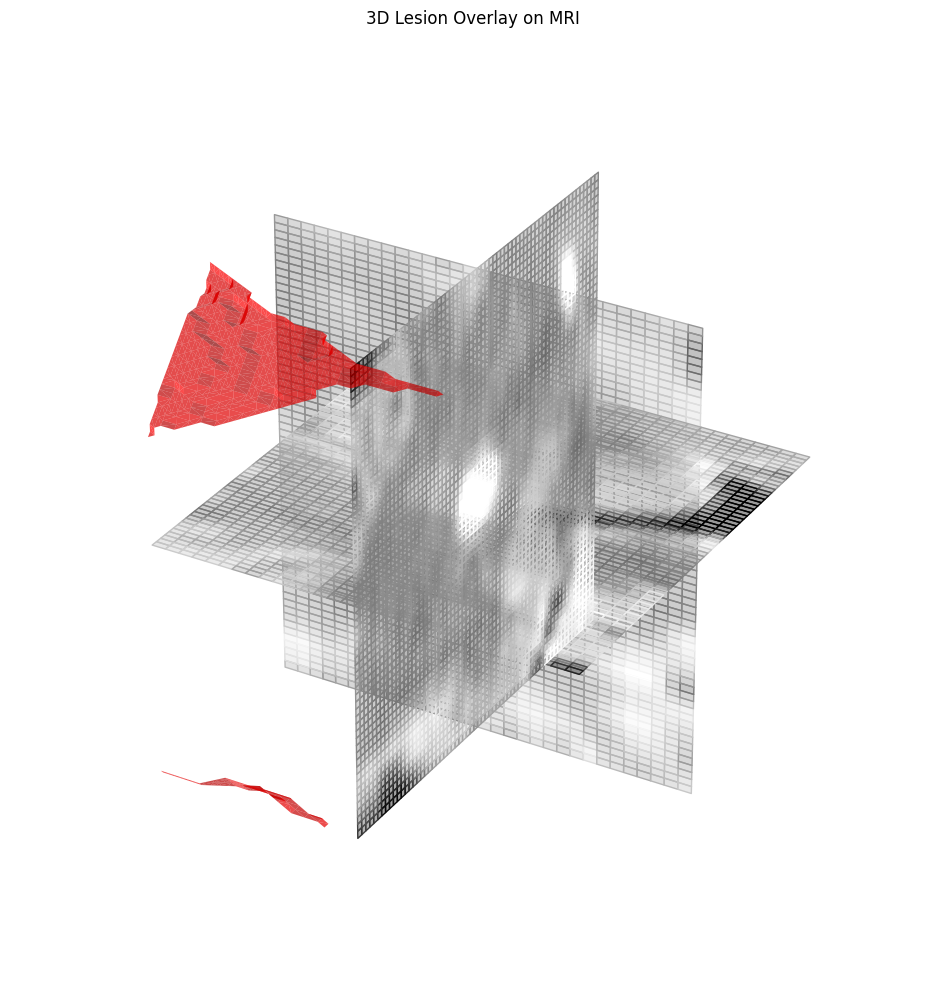

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import label, regionprops, marching_cubes
import os

# --- Load lesion mask ---
mask_img = nib.load("/content/P2_T4_MASK_lesion13.nii.gz")
# mask_data = mask_img.get_fdata()

# # Find largest lesion
# labeled = label(mask_data > 0)
# regions = regionprops(labeled)
# largest_region = max(regions, key=lambda r: len(r.coords))
# coords = largest_region.coords

# # Create binary mask for that lesion
# lesion_mask = np.zeros_like(mask_data)
# lesion_mask[tuple(coords.T)] = 1

# # --- Load MRI (prefer T2, fallback T1) ---
# mri_path = mask_path.replace("_MASK.nii.gz", "_T2.nii.gz")
# if not os.path.exists(mri_path):
#     mri_path = mask_path.replace("_MASK.nii.gz", "_T1.nii.gz")

mri_img = nib.load("/content/P2_T4_MASK_lesion13.nii.gz")
mri_data = mri_img.get_fdata()
mri_data = np.nan_to_num(mri_data)

# --- Normalize MRI intensity ---
mri_norm = (mri_data - np.percentile(mri_data, 1)) / (np.percentile(mri_data, 99) - np.percentile(mri_data, 1))
mri_norm = np.clip(mri_norm, 0, 1)

# --- Create 3D lesion mesh ---
verts, faces, normals, values = marching_cubes(lesion_mask, level=0.5)

# --- Prepare plot ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Get slice midpoints
x_mid = mri_norm.shape[0] // 2
y_mid = mri_norm.shape[1] // 2
z_mid = mri_norm.shape[2] // 2

# --- Axial slice (XY plane) ---
X, Y = np.meshgrid(np.arange(mri_norm.shape[0]), np.arange(mri_norm.shape[1]))
Z = np.full_like(X, z_mid)
ax.plot_surface(X, Y, Z, facecolors=plt.cm.gray(mri_norm[:, :, z_mid].T), rstride=1, cstride=1, shade=False, alpha=0.4)

# --- Coronal slice (XZ plane) ---
X, Z = np.meshgrid(np.arange(mri_norm.shape[0]), np.arange(mri_norm.shape[2]))
Y = np.full_like(X, y_mid)
ax.plot_surface(X, Y, Z, facecolors=plt.cm.gray(mri_norm[:, y_mid, :].T), rstride=1, cstride=1, shade=False, alpha=0.4)

# --- Sagittal slice (YZ plane) ---
Y, Z = np.meshgrid(np.arange(mri_norm.shape[1]), np.arange(mri_norm.shape[2]))
X = np.full_like(Y, x_mid)
ax.plot_surface(X, Y, Z, facecolors=plt.cm.gray(mri_norm[x_mid, :, :].T), rstride=1, cstride=1, shade=False, alpha=0.4)

# --- Add red lesion mesh ---
ax.plot_trisurf(
    verts[:, 0], verts[:, 1], faces, verts[:, 2],
    color='red', lw=0.1, alpha=0.7, shade=True
)

# --- Aesthetic settings ---
ax.set_box_aspect([1, 1, 1])
ax.view_init(30, 120)  # nice starting angle
ax.set_title(f"3D Lesion Overlay on MRI\n")
ax.set_axis_off()

plt.tight_layout()
plt.show()
